# KaggleRossmanStoreSales

## 分析

### 数据的探索


In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import itertools
import numpy as np
from datetime import datetime, date
from IPython.display import display
from datetime import datetime

In [ ]:
train = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/train.csv', dtype = {'StateHoliday':str})
store = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/store.csv', dtype = {'PromoInterval':str, 'CompetitionOpenSinceYear':str, 'CompetitionOpenSinceMonth':str})

In [238]:
display(train.head())
display(store.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN


> 由于有许多天店铺是关门的，如果直接求均值，无法体现其销售额真实的均值，因此先去掉Sales=0的数据

In [252]:
# 给出Sales的最大值，最小值，平均值，中值
Sales_train = train[train['Sales'] != 0]
Sales = Sales_train['Sales']
print("Sales的最小值为:{:,.2f}".format(min(Sales)))
print("Sales的最大值为:{:,.2f}".format( max(Sales)))
print("Sales的均值为:{:,.2f}".format(np.mean(Sales)))
print("Sales的中位数为:{:,.2f}".format(np.median(Sales)))
print("Sales的标准差为:{:,.2f}".format(Sales.std()))

Sales的最小值为:46.00
Sales的最大值为:41,551.00
Sales的均值为:6,955.96
Sales的中位数为:6,369.00
Sales的标准差为:3,103.82


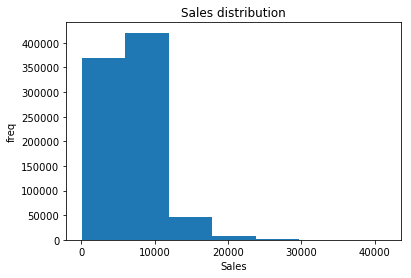

In [253]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(Sales, bins=7)
plt.title('Sales distribution')
plt.xlabel('Sales')
plt.ylabel('freq')
plt.show()

### 探索性可视化

想探究一下每个店铺的历史平均销售额与竞争店铺的距离是什么关系？

In [266]:
sub_Sales_train = Sales_train[['Store', 'Sales']]
mean_sales = sub_Sales_train.groupby('Store').apply(np.mean)

In [271]:
CompDist_store = store[['Store', 'CompetitionDistance']]
sales_distance = pd.merge(mean_sales, CompDist_store)

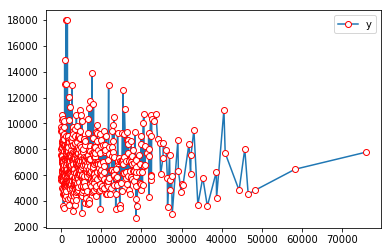

In [349]:
sales_distance = sales_distance.sort_values(by='CompetitionDistance', axis=0, ascending=True)
sales_distance = sales_distance[['Sales', 'CompetitionDistance']]
mean_sales_distance = sales_distance.groupby('CompetitionDistance').apply(np.mean)
sub_mean_sales_distance = mean_sales_distance.iloc[0:700]

plt.plot(sub_mean_sales_distance.CompetitionDistance, sub_mean_sales_distance.Sales, marker='o', mec='r', mfc='w',label=u'y')
#plt.plot(plot_data.Date, plot_data.pred, marker='o', mec='b', mfc='w',label=u'y_hat')
plt.legend()
plt.show()

## 特征工程
### 第一阶段

#### 1. 得到train_all
train.csv有数据缺失，数据集的时间范围内，并不是每个店铺的每一天都有数据的，对缺失的补充0。

In [235]:
# 获取train的时间区间，以日为跨度
Date = train['Date']
Store = train['Store']
date = pd.to_datetime(Date)
min_date = min(date)
max_date = max(date)
date_range = pd.date_range(min_date, max_date)

# 获取所有店铺
Store_unq = Store.unique()

# 将train中的Date也改为时间格式
train['Date'] = date

In [83]:
# 对店铺和日期做笛卡尔积，这种方法做笛卡尔积的效率会更高
import itertools 
store_date = list()
for i in itertools.product(Store_unq, date_range):  
    store_date.append(np.array(i))
    
# 得到每个店铺对应每一天的数据，计算dtrain_cartesian的行数
train_cartesian = DataFrame(store_date, columns=['Store', 'Date'])
print("总行数是", train_cartesian.iloc[:, 0].size)

总行数是 1050330


In [84]:
# 增加值为0的列，列名和train保持一致
train_cartesian = train_cartesian.reindex(columns=train.columns, fill_value=0)

# 获得Date对应周几。得到周几后，必须要+1，因为train里面的DayOfWeek是从1到7的。
weekday = [i.weekday() for i in train_cartesian['Date']]
train_cartesian['DayOfWeek'] = [i+1 for i in weekday]

# 获取train和train_cartesian的差集
train2_cartesian = train_cartesian.append(train)
diff_train = train2_cartesian.drop_duplicates(subset=['Store', 'Date'],keep=False)

# 获得train_all, 并打印其行数
train_all = train.append(diff_train)
print("train_all的行数为：", train_all.iloc[:, 0].size)

train_all的行数为： 1050330


> 经过上述步骤处理后的数据集为：train_all

#### 2. 获得竞争对手开业时间CompeteOpenDate

CompeteOpenDate是字符型。

In [85]:
CompetitionOpenSinceYear = store['CompetitionOpenSinceYear']
CompetitionOpenSinceMonth = store['CompetitionOpenSinceMonth']
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN


In [86]:

def get_CompteOpenDate(data):
    
    is_na = list(data.loc[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].isnull())
    if True in is_na:
        return(0)
    else:
        opendate = data['CompetitionOpenSinceYear']+'-' + data['CompetitionOpenSinceMonth']+'-01'
    
        data['CompeteOpenDate'] = opendate#pd.to_datetime(opendate, format="%Y-%m-%d")
        #data['CompeteOpenDate'] = datetime.strptime(opendate, "%Y-%m-%d")
        return(data)
    

In [93]:
store = store.apply(get_CompteOpenDate, axis=1)

> 经过上述步骤处理后的数据集为：store

#### 3. 处理成one-hot-vector

对train_all里的StateHoliday，DayOfWeek(为了不让其值影响到特征之间距离的计算)做one-hot处理，对store里的StoreType，Assortment做one-hot处理

In [89]:
# 原来的train_all['StateHoliday']存在问题：‘0’和0共存。
train_all['StateHoliday'] = train_all.StateHoliday.apply(lambda x: 0 if x=='0' else x)

In [94]:
# 下面做one-hot-vector的处理
train_all_onehot = pd.get_dummies(train_all, columns=['DayOfWeek', 'StateHoliday'])
store_onehot = pd.get_dummies(store, columns=['StoreType'])

In [95]:
# 由于Assortment的取值大小是有一定意义的，因此，使用数值的映射。
# Assortment_mapping = {label:idx for idx,label in enumerate(set(store['Assortment']))} 
Assortment_mapping = {'a':1, 'b': 2, 'c':3}
store_onehot['Assortment'] = store_onehot['Assortment'].map(Assortment_mapping)

> 经过该步骤处理后的数据集为：train_all_onehot和store_onehot

#### 4. CompeteOpen竞争对手是否开门

增加字段 CompeteOpen，判断竞争对手是否营业。通过Date >= CompetitionOpenDate和Open两个一起判断。也就是说首先判断CompetitionOpenDate是否早于Date，如果是，与该日期本店铺的Open一致，如果不是则为未开门0。

In [108]:
# 首先要做的是合并train_all_onehot和store_onehot
all_data = pd.merge(train_all_onehot, store_onehot, on='Store', how='left')
all_data['CompeteOpenDate'] = pd.to_datetime(all_data['CompeteOpenDate'])

In [110]:
def judge_compete_open(date, compete_date, opened):
    if date > compete_date and opened == 1:
        return(1)
    else:
        return(0)

In [111]:
all_data['CompeteOpen'] = all_data.apply(lambda x: judge_compete_open(x.Date, x.CompeteOpenDate, x.Open), axis=1)

> 经过该步骤处理后的数据集为：all_data

#### 5. Promo2Active商品当天是否有特殊促销活动（Promo2）

判断当天是否有Promo2的促销活动。

In [112]:
all_data.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompeteOpenDate,StoreType_0,StoreType_a,StoreType_b,StoreType_c,StoreType_d,CompeteOpen
0,1,2015-07-31,5263,555,1,1,1,0,0,0,...,NaN,NaN,NaN,2008-09-01,0.0,0.0,0.0,1.0,0.0,1
1,2,2015-07-31,6064,625,1,1,1,0,0,0,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,0.0,1.0,0.0,0.0,0.0,1
2,3,2015-07-31,8314,821,1,1,1,0,0,0,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,0.0,1.0,0.0,0.0,0.0,1
3,4,2015-07-31,13995,1498,1,1,1,0,0,0,...,NaN,NaN,NaN,2009-09-01,0.0,0.0,0.0,1.0,0.0,1
4,5,2015-07-31,4822,559,1,1,1,0,0,0,...,NaN,NaN,NaN,2015-04-01,0.0,1.0,0.0,0.0,0.0,1


In [141]:
def judge_promot2(date, p2SinceWeek, p2SinceYear, p2Interval, promot2):
    date_year = date.year
    date_mon = date.month
    date_week = date.week
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    date_mon_abbr = month_abbr[date_mon-1]
    judge = (date_year > p2SinceYear or (date_year == p2SinceYear and date_week > p2SinceWeek)) and date_mon_abbr in p2Interval
        
    return(promot2*judge)
  


In [142]:
all_data['Promo2Active'] = all_data.apply(lambda x: judge_promot2(x.Date, x.Promo2SinceWeek, x.Promo2SinceYear, x.PromoInterval, x.Promo2), axis=1)


#### 6. 根据Gert建议增加特征

参考[Gert](https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)的工作，考虑一些特征，在all_data中增加特征：week, year, month, day

In [149]:
all_data['week'] = all_data.Date.apply(lambda x: x.week)

In [151]:
all_data['month'] = all_data.Date.apply(lambda x: x.month)
all_data['year'] = all_data.Date.apply(lambda x: x.year)
all_data['day'] = all_data.Date.apply(lambda x: x.day)

In [153]:
all_data.to_pickle('all_data.pkl')

> 经过该步骤处理后的数据集为：all_data增加了一列Promo2Active。并且已经保存为pickle，之后可以不经过上面的运算，可以直接加载数据集`pd.read_pickle('all_data.pkl')`

#### 7. 删除一些不使用的特征

有一些特征通过上面利用到了，需要删除。为了划分训练集合测试集，首先要保留Date和Sales

- 确定需要删除的列有： Promo2SinceWeek, Promo2SinceYear, PromoInterval, Promo2, CompeteOpenDate, CompetitionOpenSinceYear, CompetitionOpenSinceMonth, 

In [4]:
# 读取pickle文件
all_data = pd.read_pickle('all_data.pkl')
all_data.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,CompeteOpen,Promo2Active,week,month,year,day
0,1,2015-07-31,5263,555,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,1,0.0,31,7,2015,31
1,2,2015-07-31,6064,625,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,1,1.0,31,7,2015,31
2,3,2015-07-31,8314,821,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,1,1.0,31,7,2015,31
3,4,2015-07-31,13995,1498,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,1,0.0,31,7,2015,31
4,5,2015-07-31,4822,559,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,1,0.0,31,7,2015,31


In [5]:
del_colums = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2','CompeteOpenDate',
              'CompetitionOpenSinceYear','CompetitionOpenSinceMonth']
sub_all_data = all_data.drop(del_colums, axis=1)


In [6]:
sub_all_data.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,CompeteOpen,Promo2Active,week,month,year,day
0,1,2015-07-31,5263,555,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,1,0.0,31,7,2015,31
1,2,2015-07-31,6064,625,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,1,1.0,31,7,2015,31
2,3,2015-07-31,8314,821,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,1,1.0,31,7,2015,31
3,4,2015-07-31,13995,1498,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,1,0.0,31,7,2015,31
4,5,2015-07-31,4822,559,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,1,0.0,31,7,2015,31


## 模型训练和预测

### 划分训练集、验证集和测试集

根据Date来划分训练集、验证集和测试集：原则是validation data和test data分别保留6周的数据，因此按照时间划分后，从从2013-01-01到2015-05-08的数据作为train_data，从2015-05-09到2015-06-19的数据作为validation_data，从2015-06-20到2015-07-31的数据作为test_data。

In [7]:
# 这里使用位运算，可以得到两个条件的子集
train = sub_all_data[sub_all_data.Date <= datetime.strptime('2015-05-08', '%Y-%m-%d') ]
test = sub_all_data[sub_all_data.Date >= datetime.strptime('2015-06-20', '%Y-%m-%d')]
valid = sub_all_data.loc[(sub_all_data['Date'] > datetime.strptime('2015-05-08', '%Y-%m-%d')) 
                         & (datetime.strptime('2015-06-19', '%Y-%m-%d') >= sub_all_data['Date'])]

In [8]:
len(valid)+len(train)+len(test)

1050330

所有的特征如下：

In [12]:
train.columns

Index(['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Assortment',
       'CompetitionDistance', 'StoreType_0', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'CompeteOpen', 'Promo2Active', 'week',
       'month', 'year', 'day'],
      dtype='object')

### 评价指标

选择RMSPE作为评价指标，定义为：

$RMSPE=\sqrt{\frac{1}{n}\sum_{i=1}^N(\frac{y_i-\hat{y_i}}{y_i})^2} $




In [111]:
def evalerror(preds, dtrain, evals = True):
    if evals:
        labels = dtrain.get_label()
    else:
        labels = dtrain
    zero_index = np.where(labels != 0)
    # return a pair metric_name, result
    # since preds are margin(before logistic transformation, cutoff at 0)
    
    y = np.exp(labels[zero_index]) - 1
    pred = np.exp(preds[zero_index]) - 1

    rmspe = np.sqrt(np.mean(np.square(np.divide(pred, y) - 1)))
    return('RMSPE', rmspe)



### XGboost模型训练

训练XGboost模型

In [33]:
import xgboost as xgb
import math

In [113]:
# 准备数据，对Y进行log处理
X_train = train.drop(['Date', 'Sales'], axis=1)
Y_train = np.log(train['Sales'] + 1)

X_valid = valid.drop(['Date', 'Sales'], axis=1)
Y_valid = np.log(valid['Sales'] + 1)

X_test = test.drop(['Date', 'Sales'], axis=1)
Y_test = np.log(test['Sales'] + 1)
xg_test = xgb.DMatrix(X_test, label = Y_test)

xg_train = xgb.DMatrix(X_train, label=Y_train)
xg_valid = xgb.DMatrix(X_valid, label=Y_valid)
watchlist = [(xg_train, 'train'), (xg_valid, 'valid')]

In [109]:
param = {'max_depth':10, 'eta':0.02, 'subsample':0.9, 'colsample_bytree':0.7, 'silent':1, 
         'objective':'reg:linear' , 'booster': "gbtree"}
num_round = 3000

In [110]:
bst = xgb.train(params=param, dtrain=xg_train, num_boost_round=num_round, evals=watchlist, verbose_eval = True,
                 early_stopping_rounds = 50, maximize = False, feval=evalerror)


[0]	train-rmse:7.25448	valid-rmse:7.3003	train-RMSPE:0.999837	valid-RMSPE:0.999848
Multiple eval metrics have been passed: 'valid-RMSPE' will be used for early stopping.

Will train until valid-RMSPE hasn't improved in 50 rounds.
[1]	train-rmse:7.11326	valid-rmse:7.15677	train-RMSPE:0.99978	valid-RMSPE:0.999794
[2]	train-rmse:6.97109	valid-rmse:7.01452	train-RMSPE:0.999714	valid-RMSPE:0.999731
[3]	train-rmse:6.83177	valid-rmse:6.87504	train-RMSPE:0.999638	valid-RMSPE:0.99966
[4]	train-rmse:6.69522	valid-rmse:6.73841	train-RMSPE:0.999552	valid-RMSPE:0.999579
[5]	train-rmse:6.56142	valid-rmse:6.6045	train-RMSPE:0.999454	valid-RMSPE:0.999486
[6]	train-rmse:6.43028	valid-rmse:6.47328	train-RMSPE:0.999343	valid-RMSPE:0.999381
[7]	train-rmse:6.30178	valid-rmse:6.34474	train-RMSPE:0.999217	valid-RMSPE:0.999263
[8]	train-rmse:6.17584	valid-rmse:6.21872	train-RMSPE:0.999075	valid-RMSPE:0.999129
[9]	train-rmse:6.05262	valid-rmse:6.09586	train-RMSPE:0.998914	valid-RMSPE:0.998978
[10]	train-rmse:5

[96]	train-rmse:1.05657	valid-rmse:1.09565	train-RMSPE:0.685848	valid-RMSPE:0.699917
[97]	train-rmse:1.03581	valid-rmse:1.07486	train-RMSPE:0.678548	valid-RMSPE:0.692913
[98]	train-rmse:1.01557	valid-rmse:1.05448	train-RMSPE:0.671216	valid-RMSPE:0.685842
[99]	train-rmse:0.995725	valid-rmse:1.03419	train-RMSPE:0.663875	valid-RMSPE:0.678647
[100]	train-rmse:0.976165	valid-rmse:1.01458	train-RMSPE:0.656546	valid-RMSPE:0.671603
[101]	train-rmse:0.957012	valid-rmse:0.995371	train-RMSPE:0.64921	valid-RMSPE:0.66455
[102]	train-rmse:0.938258	valid-rmse:0.976592	train-RMSPE:0.641868	valid-RMSPE:0.657502
[103]	train-rmse:0.92033	valid-rmse:0.958192	train-RMSPE:0.634628	valid-RMSPE:0.650384
[104]	train-rmse:0.902329	valid-rmse:0.940178	train-RMSPE:0.62729	valid-RMSPE:0.643339
[105]	train-rmse:0.884687	valid-rmse:0.922515	train-RMSPE:0.61996	valid-RMSPE:0.636296
[106]	train-rmse:0.867397	valid-rmse:0.90517	train-RMSPE:0.612639	valid-RMSPE:0.62925
[107]	train-rmse:0.850453	valid-rmse:0.888164	train

[190]	train-rmse:0.201047	valid-rmse:0.22666	train-RMSPE:0.195461	valid-RMSPE:0.216543
[191]	train-rmse:0.198561	valid-rmse:0.223953	train-RMSPE:0.193389	valid-RMSPE:0.214282
[192]	train-rmse:0.196146	valid-rmse:0.221374	train-RMSPE:0.191356	valid-RMSPE:0.212131
[193]	train-rmse:0.193658	valid-rmse:0.218746	train-RMSPE:0.189257	valid-RMSPE:0.209934
[194]	train-rmse:0.191414	valid-rmse:0.216225	train-RMSPE:0.187375	valid-RMSPE:0.207819
[195]	train-rmse:0.189065	valid-rmse:0.213737	train-RMSPE:0.185406	valid-RMSPE:0.205733
[196]	train-rmse:0.186759	valid-rmse:0.211301	train-RMSPE:0.183467	valid-RMSPE:0.20369
[197]	train-rmse:0.184503	valid-rmse:0.208909	train-RMSPE:0.181577	valid-RMSPE:0.20169
[198]	train-rmse:0.182352	valid-rmse:0.206592	train-RMSPE:0.179787	valid-RMSPE:0.19975
[199]	train-rmse:0.180248	valid-rmse:0.204313	train-RMSPE:0.178035	valid-RMSPE:0.19784
[200]	train-rmse:0.17829	valid-rmse:0.202202	train-RMSPE:0.176412	valid-RMSPE:0.196064
[201]	train-rmse:0.176262	valid-rmse:0

[284]	train-rmse:0.11291	valid-rmse:0.124652	train-RMSPE:0.125417	valid-RMSPE:0.132396
[285]	train-rmse:0.112614	valid-rmse:0.124288	train-RMSPE:0.125178	valid-RMSPE:0.132087
[286]	train-rmse:0.112309	valid-rmse:0.123925	train-RMSPE:0.12493	valid-RMSPE:0.131782
[287]	train-rmse:0.112084	valid-rmse:0.123613	train-RMSPE:0.124769	valid-RMSPE:0.131527
[288]	train-rmse:0.111829	valid-rmse:0.123287	train-RMSPE:0.12458	valid-RMSPE:0.131269
[289]	train-rmse:0.111654	valid-rmse:0.123006	train-RMSPE:0.124474	valid-RMSPE:0.131054
[290]	train-rmse:0.11143	valid-rmse:0.122697	train-RMSPE:0.124316	valid-RMSPE:0.130807
[291]	train-rmse:0.111278	valid-rmse:0.122429	train-RMSPE:0.124237	valid-RMSPE:0.130628
[292]	train-rmse:0.111061	valid-rmse:0.122136	train-RMSPE:0.124071	valid-RMSPE:0.130388
[293]	train-rmse:0.110887	valid-rmse:0.121883	train-RMSPE:0.123962	valid-RMSPE:0.130194
[294]	train-rmse:0.110682	valid-rmse:0.121608	train-RMSPE:0.123803	valid-RMSPE:0.129986
[295]	train-rmse:0.110469	valid-rmse

[378]	train-rmse:0.098878	valid-rmse:0.10786	train-RMSPE:0.112906	valid-RMSPE:0.117925
[379]	train-rmse:0.09874	valid-rmse:0.107771	train-RMSPE:0.112755	valid-RMSPE:0.117834
[380]	train-rmse:0.098594	valid-rmse:0.107612	train-RMSPE:0.112602	valid-RMSPE:0.117672
[381]	train-rmse:0.098392	valid-rmse:0.107385	train-RMSPE:0.112372	valid-RMSPE:0.117427
[382]	train-rmse:0.098209	valid-rmse:0.107177	train-RMSPE:0.112138	valid-RMSPE:0.117168
[383]	train-rmse:0.098158	valid-rmse:0.107105	train-RMSPE:0.112093	valid-RMSPE:0.117107
[384]	train-rmse:0.098102	valid-rmse:0.107056	train-RMSPE:0.112042	valid-RMSPE:0.117071
[385]	train-rmse:0.097949	valid-rmse:0.106882	train-RMSPE:0.111876	valid-RMSPE:0.116898
[386]	train-rmse:0.097858	valid-rmse:0.106772	train-RMSPE:0.111786	valid-RMSPE:0.11679
[387]	train-rmse:0.097732	valid-rmse:0.106705	train-RMSPE:0.111643	valid-RMSPE:0.116718
[388]	train-rmse:0.097618	valid-rmse:0.106659	train-RMSPE:0.111519	valid-RMSPE:0.116693
[389]	train-rmse:0.097398	valid-rms

[472]	train-rmse:0.089823	valid-rmse:0.099042	train-RMSPE:0.1026	valid-RMSPE:0.108726
[473]	train-rmse:0.089796	valid-rmse:0.099015	train-RMSPE:0.10257	valid-RMSPE:0.108698
[474]	train-rmse:0.089766	valid-rmse:0.098956	train-RMSPE:0.102539	valid-RMSPE:0.108648
[475]	train-rmse:0.089747	valid-rmse:0.098946	train-RMSPE:0.102521	valid-RMSPE:0.108646
[476]	train-rmse:0.089622	valid-rmse:0.098918	train-RMSPE:0.102376	valid-RMSPE:0.108613
[477]	train-rmse:0.08951	valid-rmse:0.09885	train-RMSPE:0.102246	valid-RMSPE:0.108555
[478]	train-rmse:0.089331	valid-rmse:0.098647	train-RMSPE:0.102032	valid-RMSPE:0.108327
[479]	train-rmse:0.089312	valid-rmse:0.098628	train-RMSPE:0.102013	valid-RMSPE:0.108308
[480]	train-rmse:0.089295	valid-rmse:0.098628	train-RMSPE:0.101996	valid-RMSPE:0.108315
[481]	train-rmse:0.089051	valid-rmse:0.098369	train-RMSPE:0.101711	valid-RMSPE:0.108026
[482]	train-rmse:0.089034	valid-rmse:0.098354	train-RMSPE:0.101693	valid-RMSPE:0.10801
[483]	train-rmse:0.088838	valid-rmse:0

[566]	train-rmse:0.082054	valid-rmse:0.091638	train-RMSPE:0.093336	valid-RMSPE:0.100495
[567]	train-rmse:0.082011	valid-rmse:0.091585	train-RMSPE:0.09328	valid-RMSPE:0.100439
[568]	train-rmse:0.081953	valid-rmse:0.091526	train-RMSPE:0.093214	valid-RMSPE:0.100376
[569]	train-rmse:0.081796	valid-rmse:0.091356	train-RMSPE:0.093033	valid-RMSPE:0.10019
[570]	train-rmse:0.081653	valid-rmse:0.091198	train-RMSPE:0.092867	valid-RMSPE:0.100015
[571]	train-rmse:0.081634	valid-rmse:0.09118	train-RMSPE:0.092845	valid-RMSPE:0.099994
[572]	train-rmse:0.081555	valid-rmse:0.091082	train-RMSPE:0.092729	valid-RMSPE:0.099877
[573]	train-rmse:0.081511	valid-rmse:0.091028	train-RMSPE:0.09268	valid-RMSPE:0.099822
[574]	train-rmse:0.081433	valid-rmse:0.090953	train-RMSPE:0.092591	valid-RMSPE:0.099742
[575]	train-rmse:0.081411	valid-rmse:0.090957	train-RMSPE:0.092568	valid-RMSPE:0.099746
[576]	train-rmse:0.081264	valid-rmse:0.090805	train-RMSPE:0.09239	valid-RMSPE:0.099568
[577]	train-rmse:0.081246	valid-rmse:

[660]	train-rmse:0.076171	valid-rmse:0.08578	train-RMSPE:0.086279	valid-RMSPE:0.093956
[661]	train-rmse:0.076048	valid-rmse:0.085669	train-RMSPE:0.086111	valid-RMSPE:0.093822
[662]	train-rmse:0.076029	valid-rmse:0.085639	train-RMSPE:0.08609	valid-RMSPE:0.093798
[663]	train-rmse:0.075988	valid-rmse:0.085601	train-RMSPE:0.086043	valid-RMSPE:0.093757
[664]	train-rmse:0.07597	valid-rmse:0.085587	train-RMSPE:0.086023	valid-RMSPE:0.09374
[665]	train-rmse:0.075874	valid-rmse:0.085477	train-RMSPE:0.085913	valid-RMSPE:0.093622
[666]	train-rmse:0.075836	valid-rmse:0.085435	train-RMSPE:0.085871	valid-RMSPE:0.09358
[667]	train-rmse:0.0758	valid-rmse:0.0854	train-RMSPE:0.085829	valid-RMSPE:0.093542
[668]	train-rmse:0.075678	valid-rmse:0.085292	train-RMSPE:0.085686	valid-RMSPE:0.093422
[669]	train-rmse:0.075633	valid-rmse:0.085243	train-RMSPE:0.085634	valid-RMSPE:0.093369
[670]	train-rmse:0.075607	valid-rmse:0.08522	train-RMSPE:0.085605	valid-RMSPE:0.093343
[671]	train-rmse:0.075552	valid-rmse:0.085

[754]	train-rmse:0.071179	valid-rmse:0.081029	train-RMSPE:0.080358	valid-RMSPE:0.088694
[755]	train-rmse:0.071155	valid-rmse:0.081002	train-RMSPE:0.080331	valid-RMSPE:0.088666
[756]	train-rmse:0.071121	valid-rmse:0.080968	train-RMSPE:0.080293	valid-RMSPE:0.08863
[757]	train-rmse:0.071044	valid-rmse:0.080898	train-RMSPE:0.080204	valid-RMSPE:0.088553
[758]	train-rmse:0.070942	valid-rmse:0.080806	train-RMSPE:0.080067	valid-RMSPE:0.088435
[759]	train-rmse:0.07084	valid-rmse:0.080697	train-RMSPE:0.079949	valid-RMSPE:0.088316
[760]	train-rmse:0.070758	valid-rmse:0.080602	train-RMSPE:0.079853	valid-RMSPE:0.088213
[761]	train-rmse:0.070746	valid-rmse:0.080601	train-RMSPE:0.079841	valid-RMSPE:0.08821
[762]	train-rmse:0.070682	valid-rmse:0.080528	train-RMSPE:0.079767	valid-RMSPE:0.088131
[763]	train-rmse:0.070645	valid-rmse:0.080494	train-RMSPE:0.079725	valid-RMSPE:0.088094
[764]	train-rmse:0.070558	valid-rmse:0.080412	train-RMSPE:0.07962	valid-RMSPE:0.088
[765]	train-rmse:0.070523	valid-rmse:0.

[848]	train-rmse:0.06607	valid-rmse:0.07624	train-RMSPE:0.074268	valid-RMSPE:0.083308
[849]	train-rmse:0.066008	valid-rmse:0.076184	train-RMSPE:0.074188	valid-RMSPE:0.083237
[850]	train-rmse:0.065963	valid-rmse:0.076162	train-RMSPE:0.074131	valid-RMSPE:0.083212
[851]	train-rmse:0.065899	valid-rmse:0.0761	train-RMSPE:0.074058	valid-RMSPE:0.083146
[852]	train-rmse:0.06584	valid-rmse:0.076048	train-RMSPE:0.073988	valid-RMSPE:0.083089
[853]	train-rmse:0.065764	valid-rmse:0.075973	train-RMSPE:0.073898	valid-RMSPE:0.083005
[854]	train-rmse:0.065734	valid-rmse:0.075952	train-RMSPE:0.073865	valid-RMSPE:0.082981
[855]	train-rmse:0.065699	valid-rmse:0.075921	train-RMSPE:0.073826	valid-RMSPE:0.082949
[856]	train-rmse:0.065677	valid-rmse:0.075901	train-RMSPE:0.0738	valid-RMSPE:0.082927
[857]	train-rmse:0.065662	valid-rmse:0.075889	train-RMSPE:0.073785	valid-RMSPE:0.082915
[858]	train-rmse:0.065646	valid-rmse:0.075877	train-RMSPE:0.073767	valid-RMSPE:0.082902
[859]	train-rmse:0.065614	valid-rmse:0.

[942]	train-rmse:0.062459	valid-rmse:0.073059	train-RMSPE:0.070004	valid-RMSPE:0.079759
[943]	train-rmse:0.062407	valid-rmse:0.073009	train-RMSPE:0.069945	valid-RMSPE:0.079706
[944]	train-rmse:0.062339	valid-rmse:0.072945	train-RMSPE:0.069864	valid-RMSPE:0.079632
[945]	train-rmse:0.062312	valid-rmse:0.072917	train-RMSPE:0.069833	valid-RMSPE:0.079602
[946]	train-rmse:0.062261	valid-rmse:0.072864	train-RMSPE:0.069772	valid-RMSPE:0.079542
[947]	train-rmse:0.062248	valid-rmse:0.072864	train-RMSPE:0.069758	valid-RMSPE:0.079541
[948]	train-rmse:0.06216	valid-rmse:0.072784	train-RMSPE:0.069653	valid-RMSPE:0.079454
[949]	train-rmse:0.062136	valid-rmse:0.072765	train-RMSPE:0.069625	valid-RMSPE:0.079432
[950]	train-rmse:0.062069	valid-rmse:0.072704	train-RMSPE:0.069544	valid-RMSPE:0.079365
[951]	train-rmse:0.061988	valid-rmse:0.072626	train-RMSPE:0.069446	valid-RMSPE:0.079276
[952]	train-rmse:0.061974	valid-rmse:0.072615	train-RMSPE:0.069431	valid-RMSPE:0.079265
[953]	train-rmse:0.061929	valid-r

从上面的计算结果可以看出来，模型在这些特征下已经产生了很好的样本内估计效果，样本外不出意外的话会造成过拟合的现象。

### 模型预测

在`test`数据集上检验模型预测精度

In [124]:
pred = bst.predict(xg_test, output_margin = True)
RMSPE = evalerror(preds = pred, dtrain = Y_test.values, evals = False)
print("在测试集（Test）上的RMSPE值为：", RMSPE[1])

在测试集（Test）上的RMSPE值为： 0.0828220014195


## 可视化

对店铺1进行可视化

In [229]:
index_storeN = np.where(test.Store == 1)[0].tolist()
storeN = test.loc[index_storeN, ['Date', 'Sales']]
storeN_pred = pred[index_storeN]
storeN_pred = np.exp(storeN_pred) - 1
storeN_pred = DataFrame(storeN_pred, index=storeN.index, columns=['pred'])

plot_data = storeN.join(storeN_pred)
plot_data.head()

,Date,Sales,pred
0,2015-07-31,5263,5212.877930
1115,2015-07-30,5020,5134.017578
2230,2015-07-29,4782,4794.335938
3345,2015-07-28,5011,5201.930176
4460,2015-07-27,6102,5873.471680


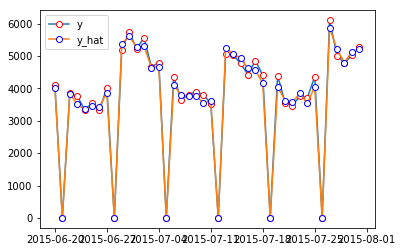

In [230]:
import matplotlib.pyplot as plt
plt.plot(plot_data.Date, plot_data.Sales, marker='o', mec='r', mfc='w',label=u'y')
plt.plot(plot_data.Date, plot_data.pred, marker='o', mec='b', mfc='w',label=u'y_hat')
plt.legend()
plt.show()

- 从上图的结果可以看出来，预测值与真实值很接近，几乎重合

对店铺8进行可视化

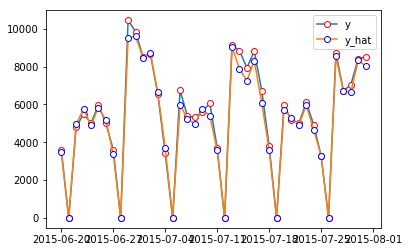

In [232]:
index_storeN = np.where(test.Store == 8)[0].tolist()
storeN = test.loc[index_storeN, ['Date', 'Sales']]
storeN_pred = pred[index_storeN]
storeN_pred = np.exp(storeN_pred) - 1
storeN_pred = DataFrame(storeN_pred, index=storeN.index, columns=['pred'])

plot_data = storeN.join(storeN_pred)
plot_data.head()

## plot
import matplotlib.pyplot as plt
plt.plot(plot_data.Date, plot_data.Sales, marker='o', mec='r', mfc='w',label=u'y')
plt.plot(plot_data.Date, plot_data.pred, marker='o', mec='b', mfc='w',label=u'y_hat')
plt.legend()
plt.show()